# Report on Marketing Engagement Drivers

In [1]:
%matplotlib inline
from PIL import Image

# Data Infos

the dataset is available here: https://archive.ics.uci.edu/ml/datasets/bank+marketing

Find the best strategies to improve for the next marketing campaign. How can the financial institution have a greater effectiveness for future marketing campaigns? In order to answer this, we have to analyze the last marketing campaign the bank performed and identify the patterns that will help us find conclusions in order to develop future strategies. In this demo, we focus on identitying the key drivers to marketing engagement

## Attribute Information:

Input variables:
### bank client data:
- age (numeric)
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')
### related with the last contact of the current campaign:
- contact: contact communication type (categorical: 'cellular','telephone')
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
### other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
### social and economic context attributes
- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric)
- cons.conf.idx: consumer confidence index - monthly indicator (numeric)
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):
- y - has the client subscribed a term deposit? (binary: 'yes','no')

# Exploratory Data Analysis

## Engagement Rate

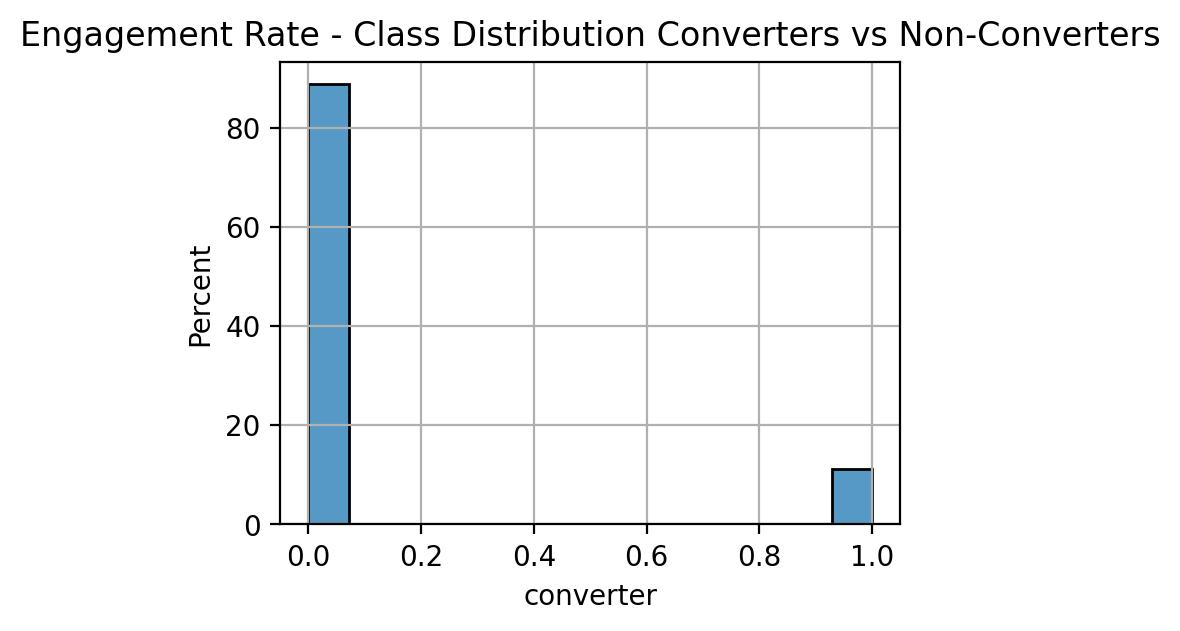

In [2]:
# open image
filepath = '../images/engagement_rate.jpg'
img = Image.open(filepath)
## resize image
#img = img.resize((1000, 750))
## save resized image
#img.save(filepath)
# show image
img

## Age Effect

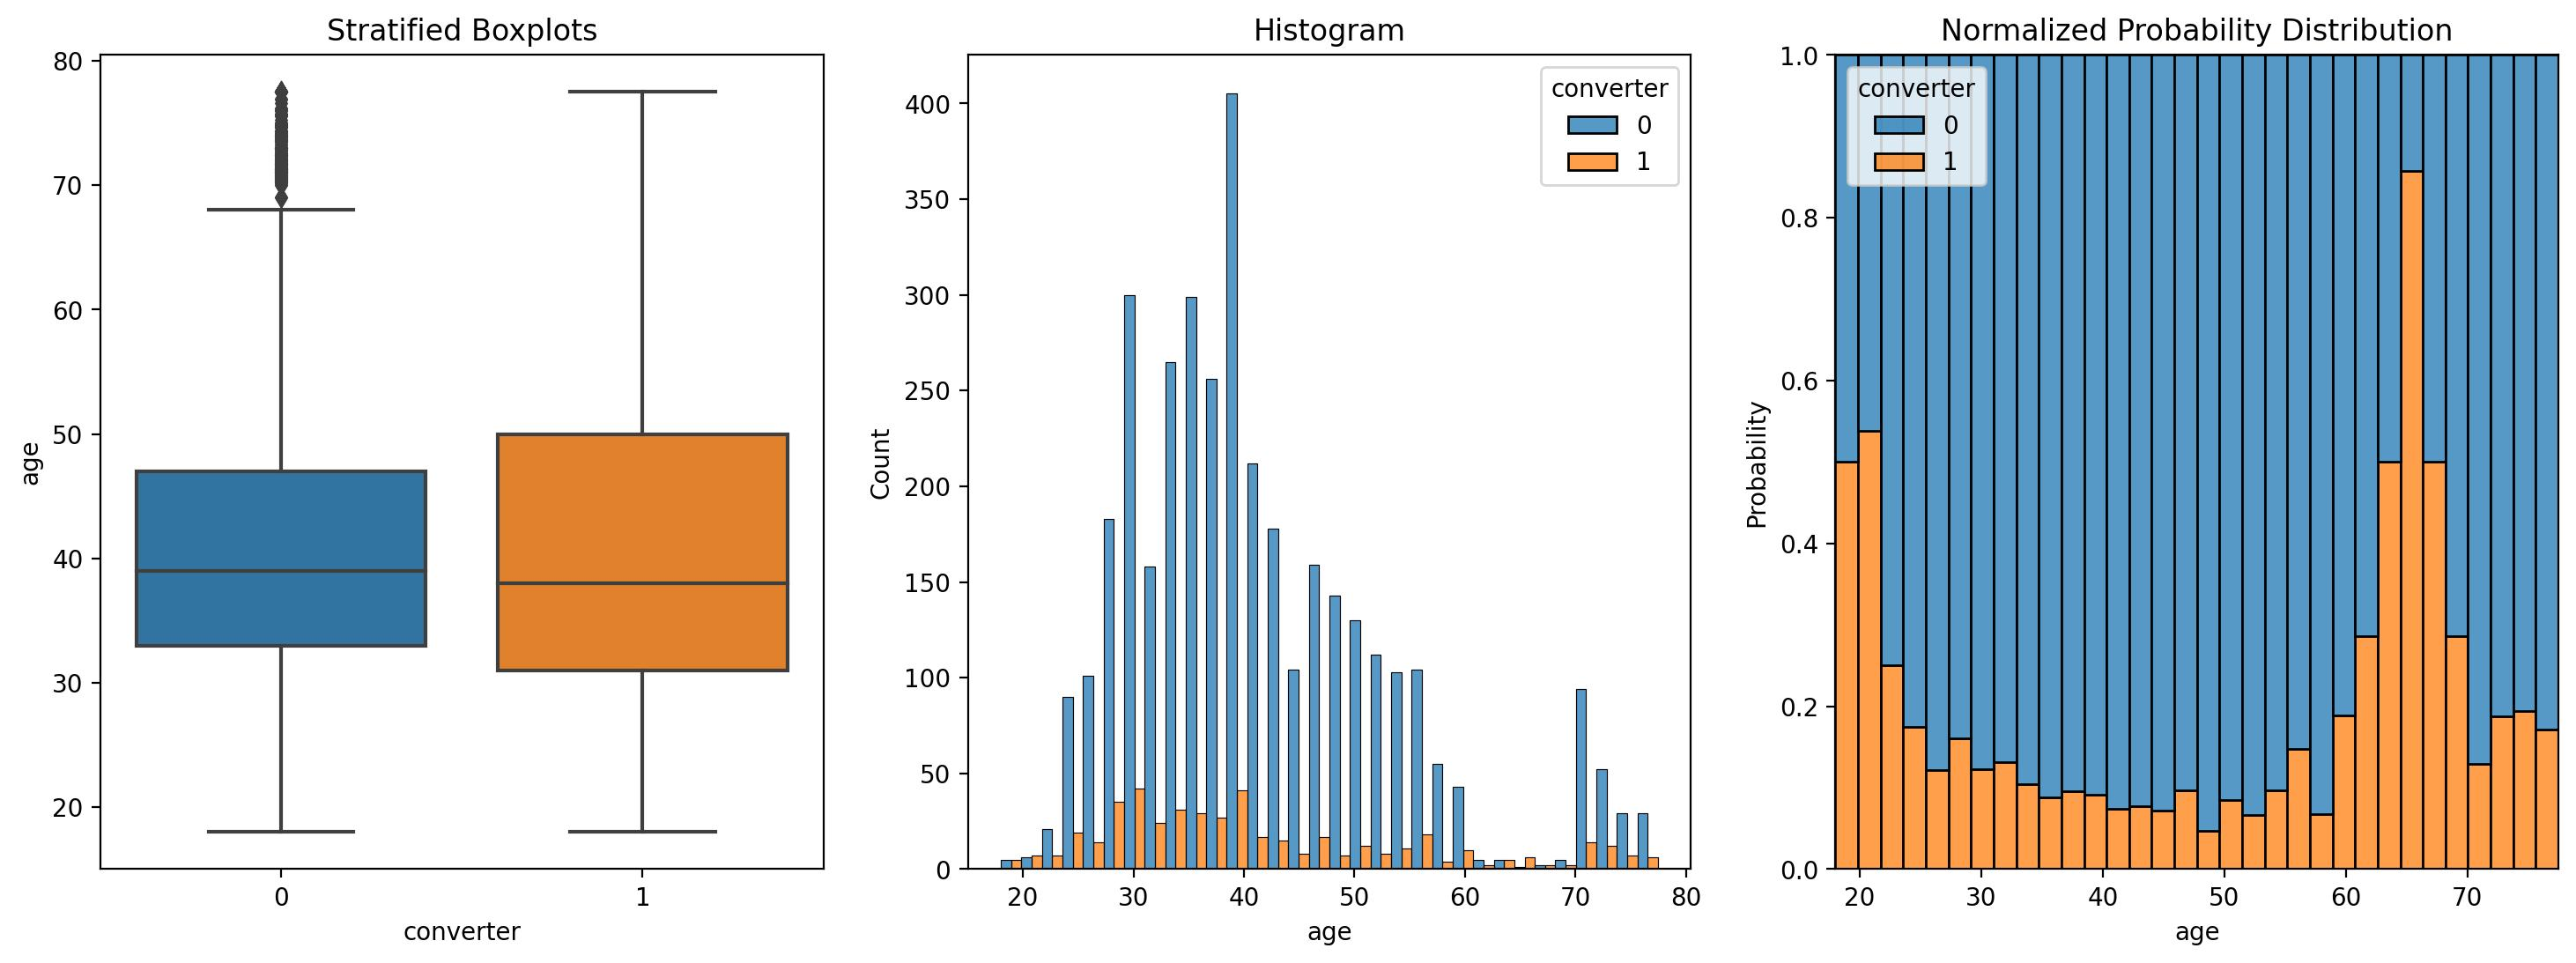

In [3]:
# open image
filepath = '../images/age_dist.jpg'
img = Image.open(filepath)
img

## Month Effect

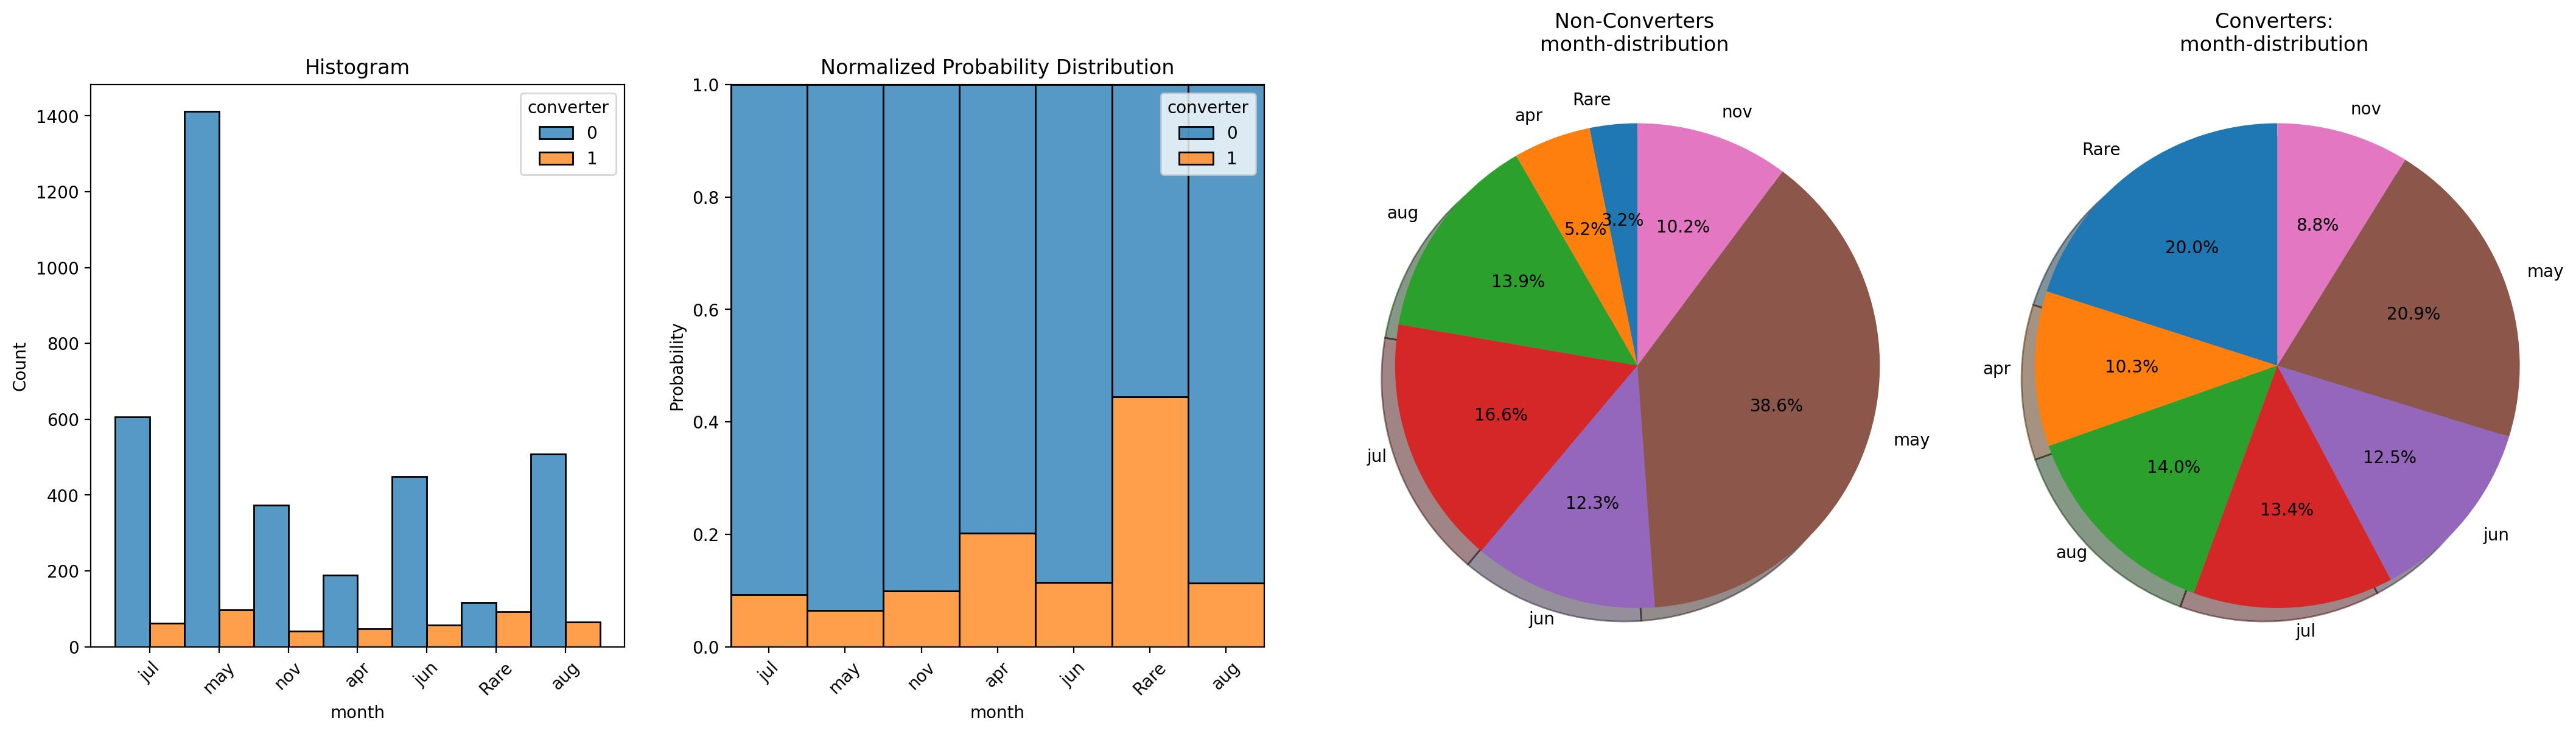

In [4]:
# open image
filepath = '../images/month_dist.jpg'
img = Image.open(filepath)
img

## Decision Tree Analysis

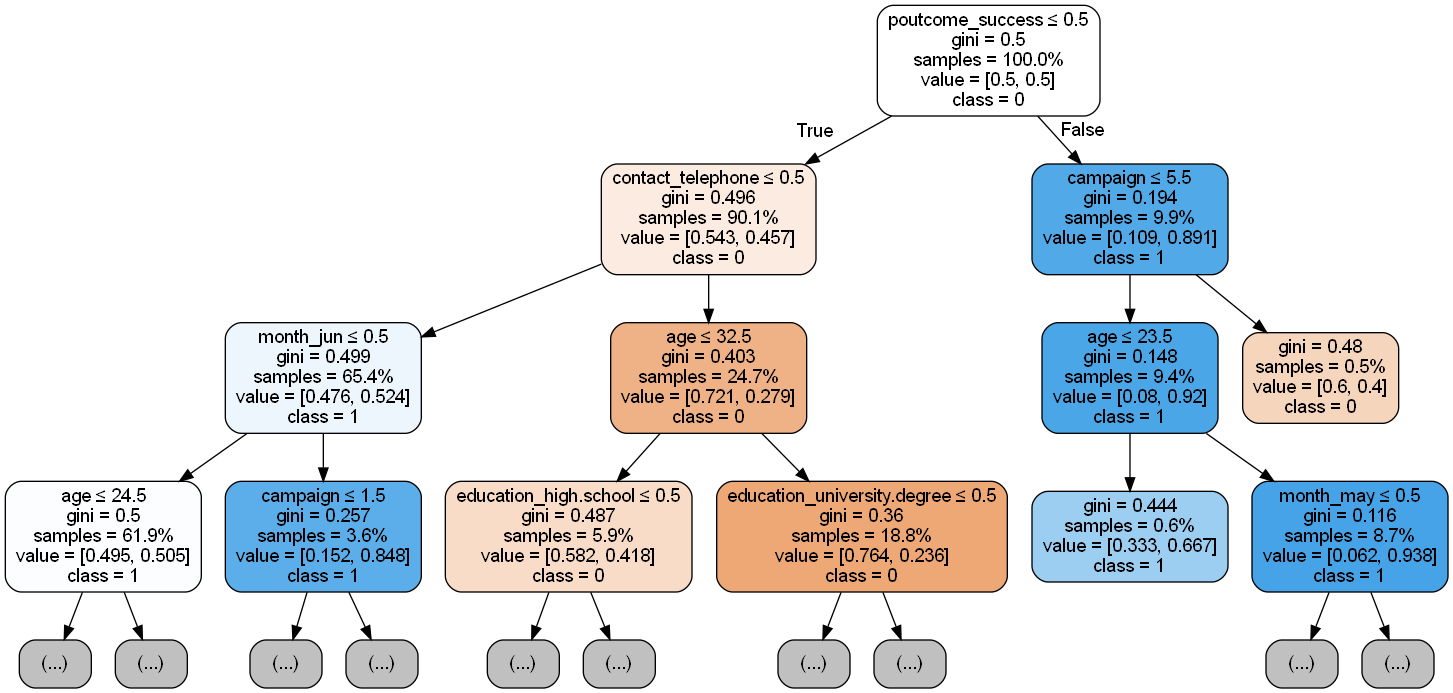

In [5]:
# open image
filepath = '../images/decision_tree_analysis.png'
img = Image.open(filepath)
img

# Engagement Drivers Analysis Based on Explainable A.I.

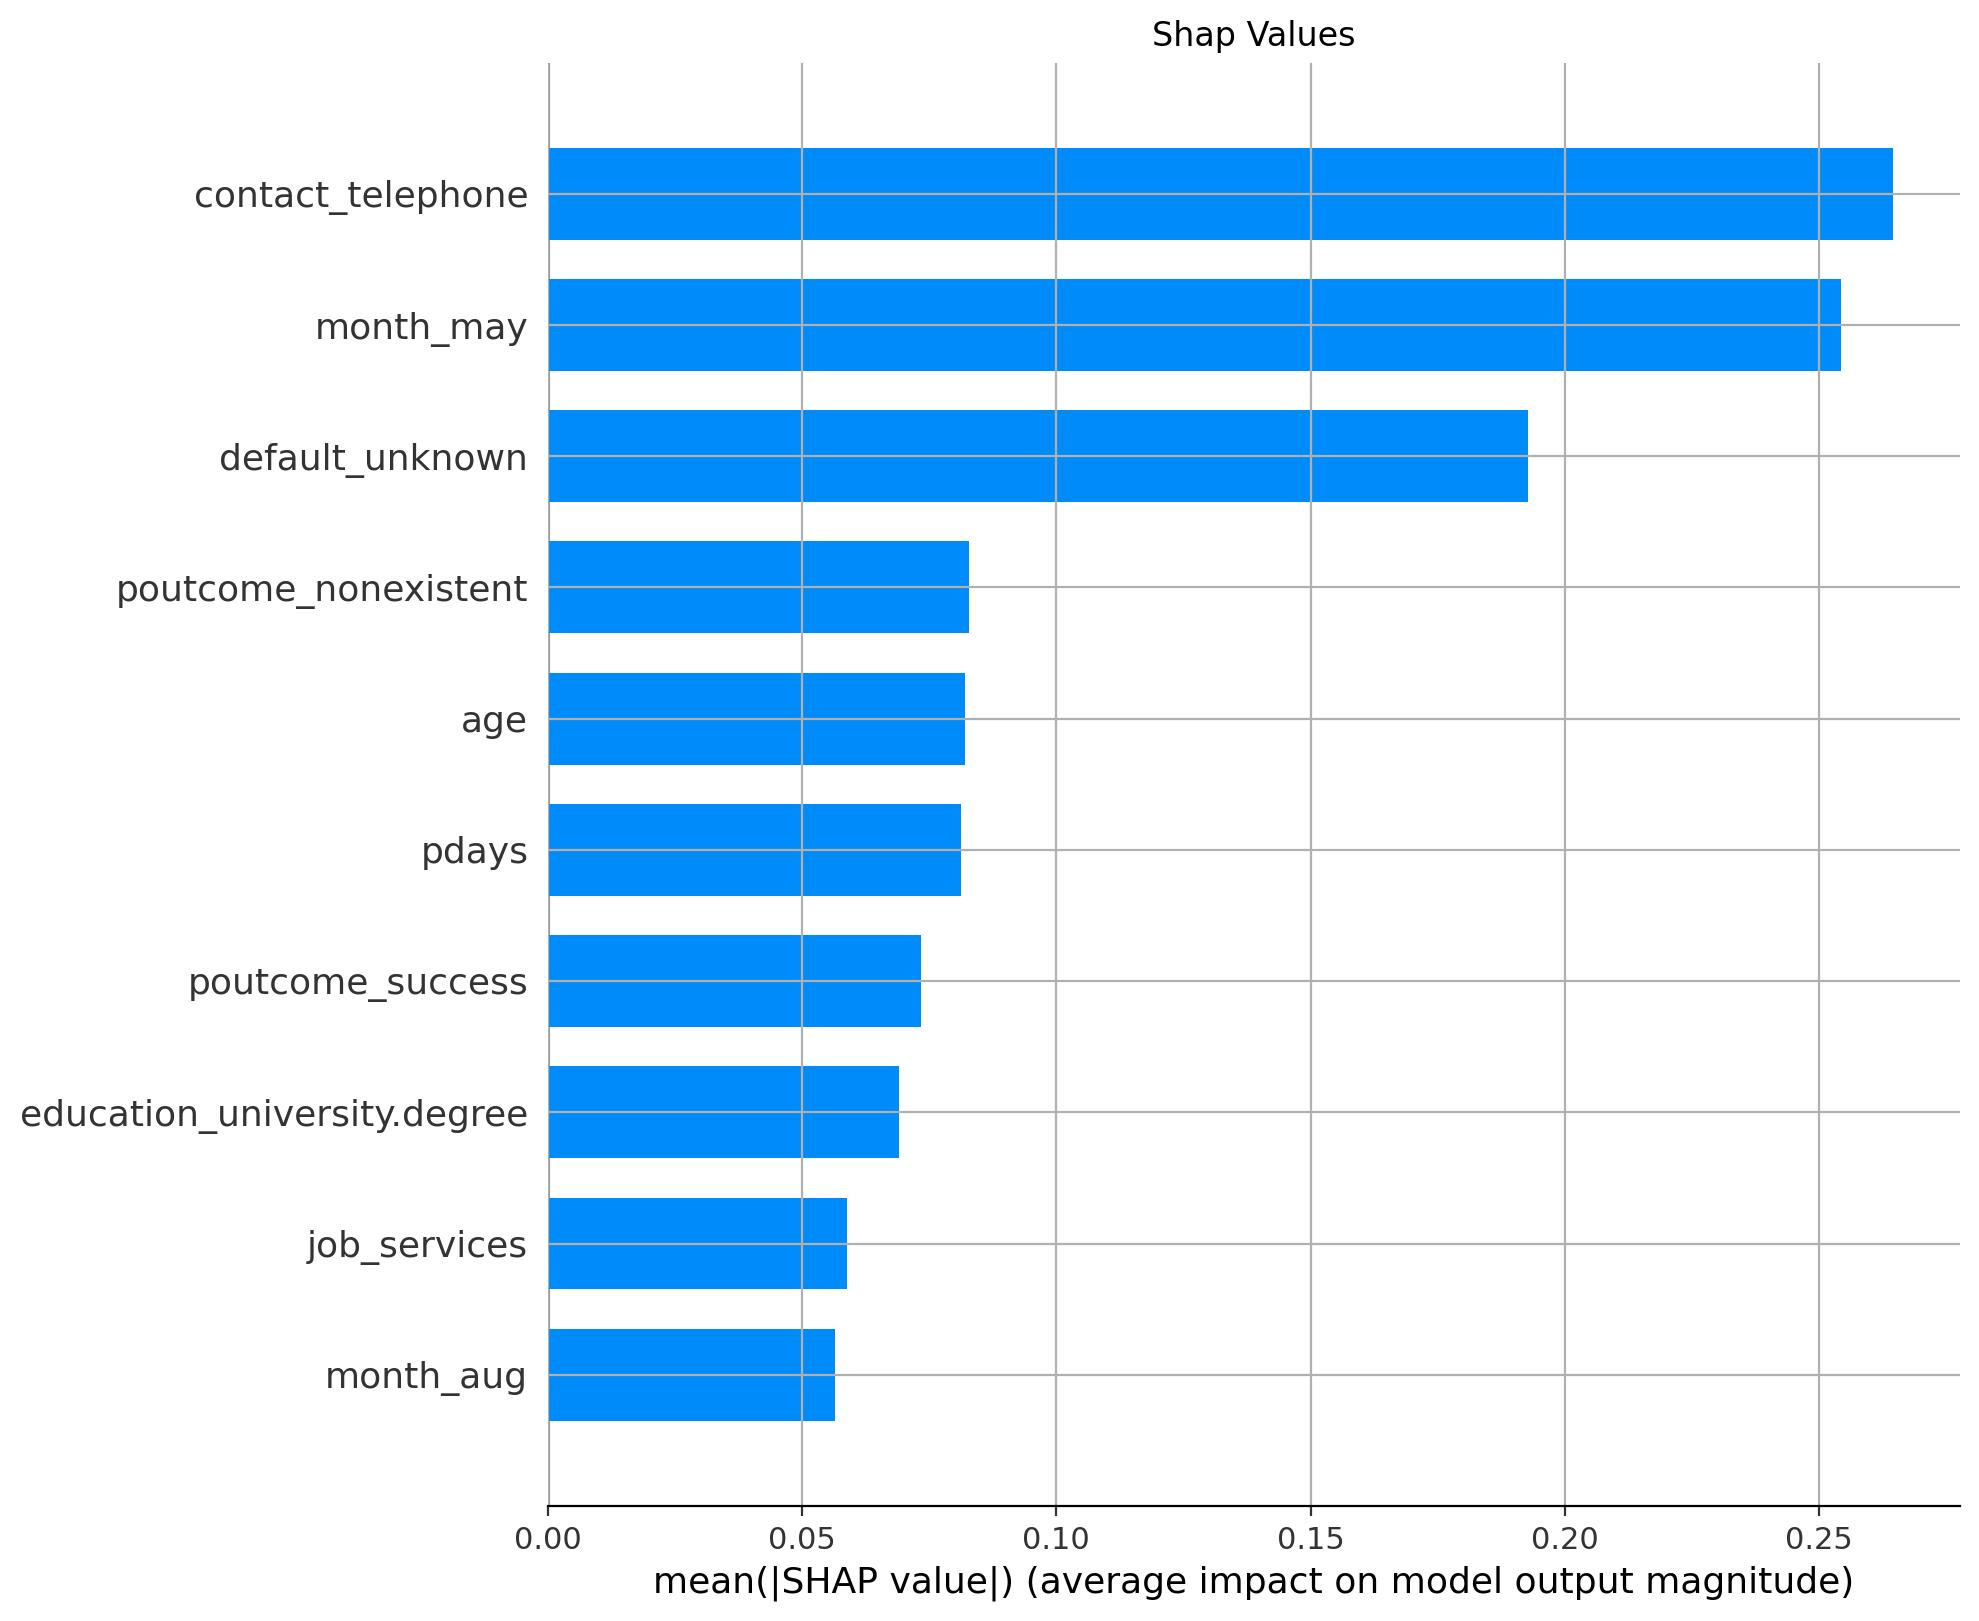

In [6]:
# open image
filepath = '../images/shap_values_bar.jpg'
img = Image.open(filepath)
img

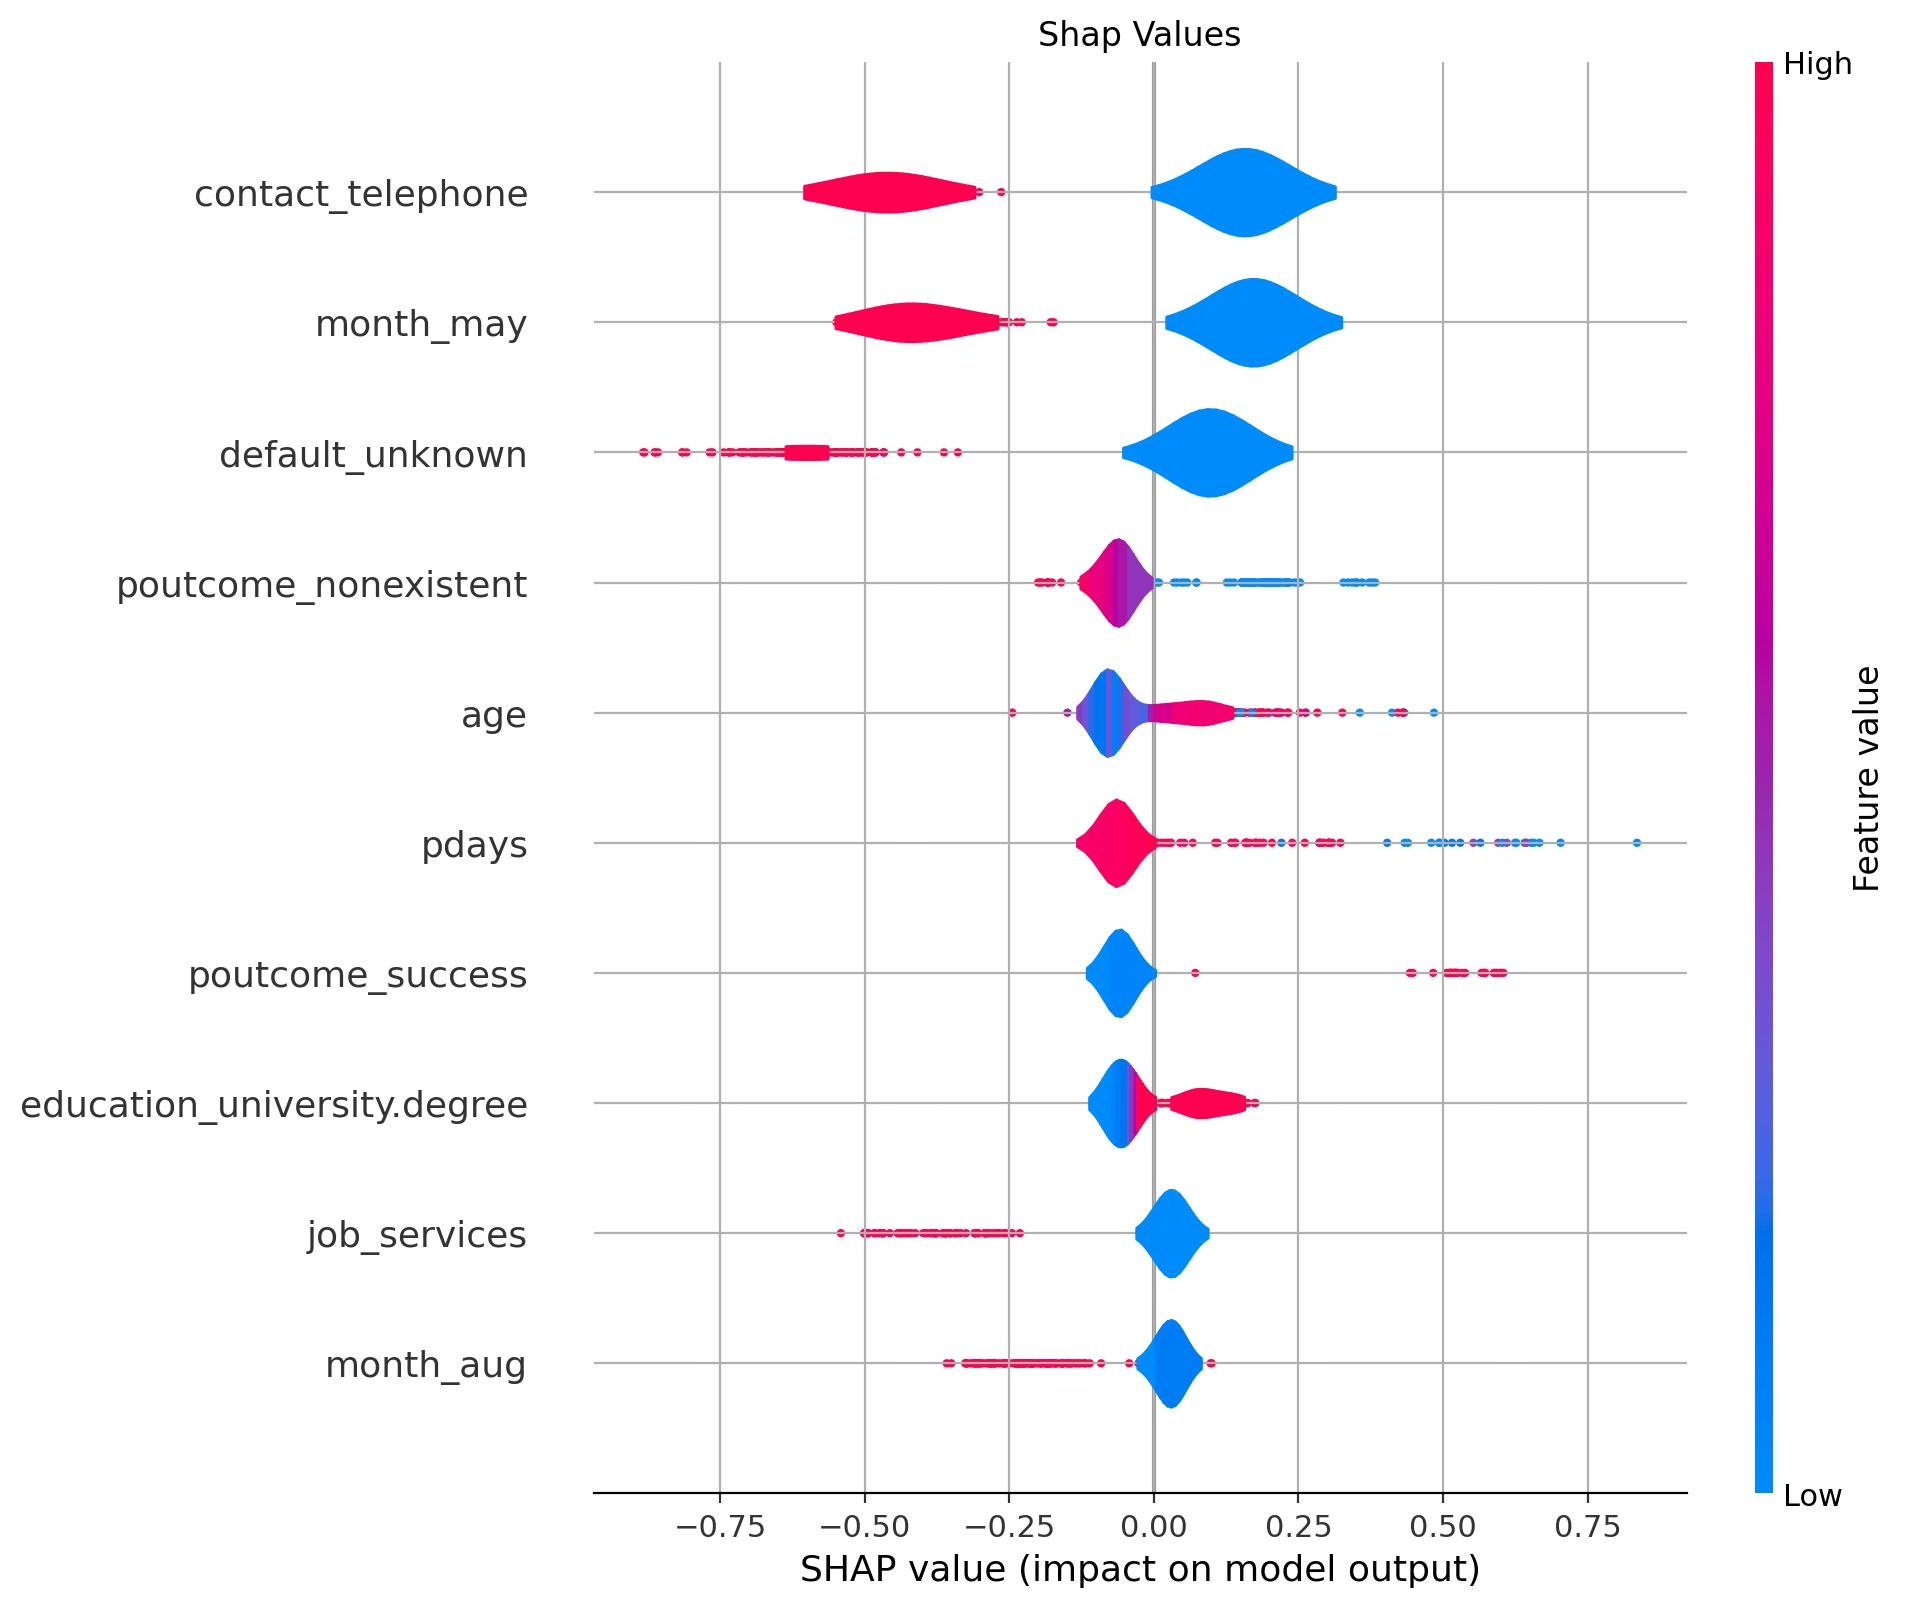

In [7]:
# open image
filepath = '../images/shap_values_violin.jpg'
img = Image.open(filepath)
img

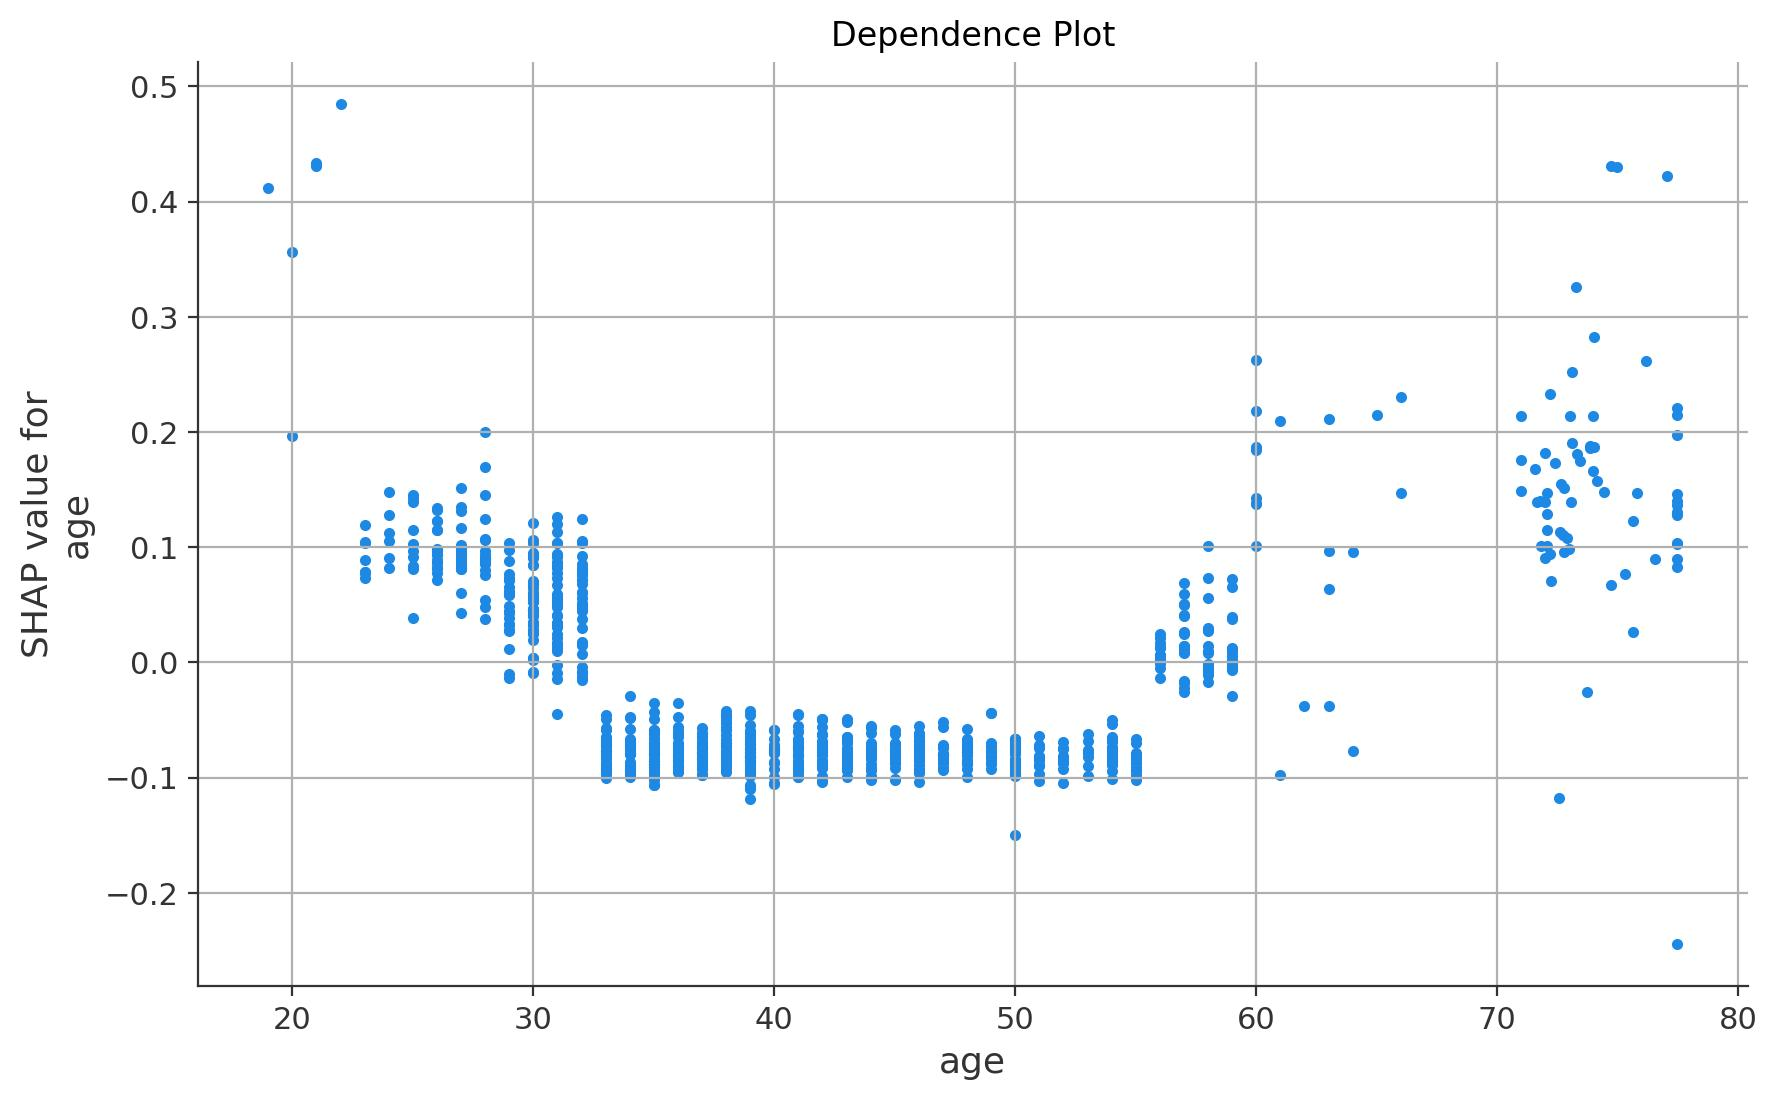

In [8]:
# open image
filepath = '../images/shap_dependence_plot_age.jpg'
img = Image.open(filepath)
img

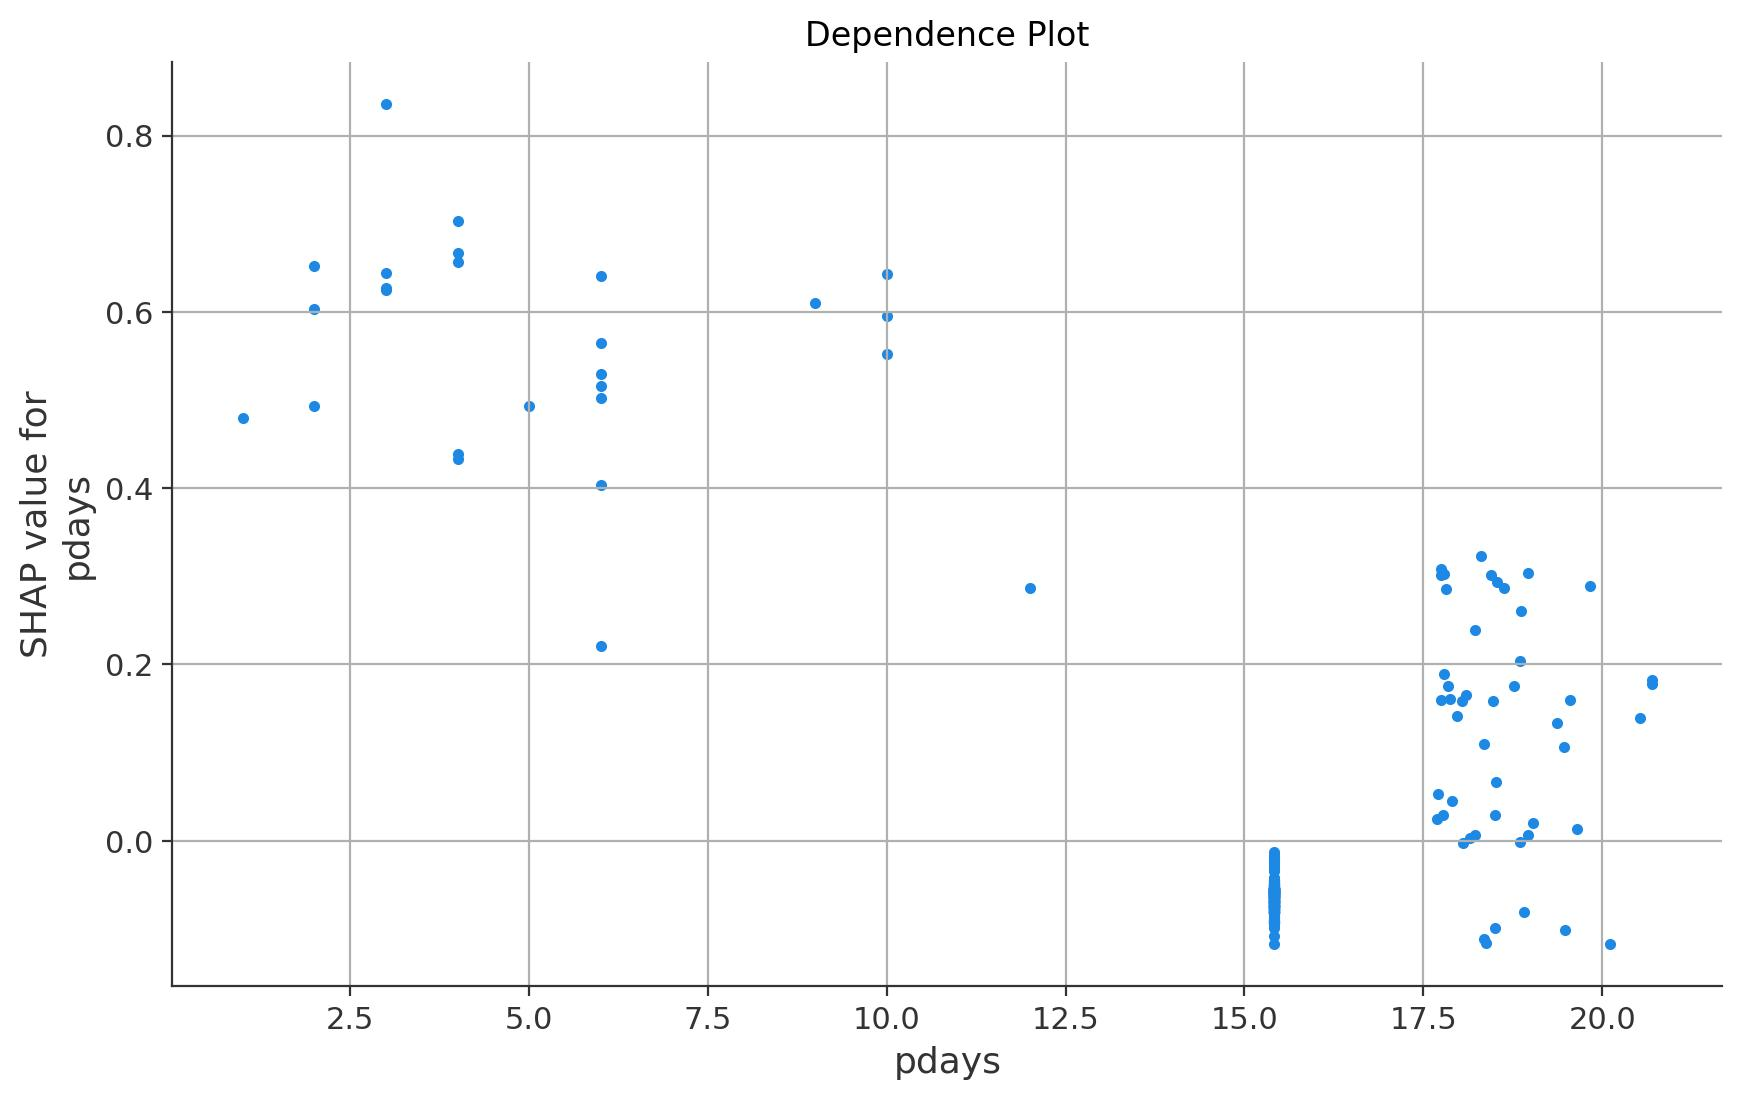

In [9]:
# open image
filepath = '../images/shap_dependence_plot_pdays.jpg'
img = Image.open(filepath)
img

# Export Notebook as PDF

In [20]:
# Export Notebook as PDF
!jupyter nbconvert 02_bank_customer_conversion_drivers_report.ipynb \
--output-dir='../reports' --to pdf --no-input --output Conversion_Drivers_Report.pdf

C:\Users\Sebas\anaconda3\envs\customer_cluster_app\lib\site-packages\traitlets\traitlets.py:2544: FutureWarning: Supporting extra quotes around strings is deprecated in traitlets 5.0. You can use '../reports' instead of "'../reports'" if you require traitlets >=5.
  warn(
[NbConvertApp] Converting notebook 02_bank_customer_conversion_drivers_report.ipynb to pdf
[NbConvertApp] Support files will be in Conversion_Drivers_Report_files\
[NbConvertApp] Making directory .\Conversion_Drivers_Report_files
[NbConvertApp] Making directory .\Conversion_Drivers_Report_files
[NbConvertApp] Making directory .\Conversion_Drivers_Report_files
[NbConvertApp] Making directory .\Conversion_Drivers_Report_files
[NbConvertApp] Making directory .\Conversion_Drivers_Report_files
[NbConvertApp] Making directory .\Conversion_Drivers_Report_files
[NbConvertApp] Making directory .\Conversion_Drivers_Report_files
[NbConvertApp] Making directory .\Conversion_Drivers_Report_files
[NbConvertApp] Writing 25923 bytes 

In [36]:
from PyPDF2 import PdfWriter, PdfReader

In [39]:
input_pdf = PdfReader(open("../reports/Conversion_Drivers_Report.pdf", "rb"))
output_pdf = PdfWriter()

for page in input_pdf.pages:
    page.compress_content_streams()
    output_pdf.add_page(page)

In [41]:
with open("../reports/Conversion_Drivers_Report_compressed.pdf", "wb") as out:
    output_pdf.write(out)